<h1> Splitting text into paragraphs </h1>

## TOC:
* [Import libraries](#Import-libraries)
* [Load the text](#Load-the-text)
* [Load Embedding model](#Load-Embedding-model)
* [Unify sentences length](#Unify-sentences-length) 
* [Embed sentences](#Embed-sentences) 
* [Create cosine similarity matrix](#Create-cosine-similarity-matrix)
* [Find splitting points](#Find-splitting-points) 
* [Split the text in paragraphs](#Split-the-text-in-paragraphs) 


 

<h2>Import libraries</b>

In [2]:
# First let import the most necessary libs
import pandas as pd
import numpy as np
import torch
# Library to import pre-trained model for sentence embeddings
from sentence_transformers import SentenceTransformer
# Calculate similarities between sentences
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
# Visualization library
import seaborn as sns
import matplotlib.pyplot as plt
# package for finding local minimas
from scipy.signal import argrelextrema
import math
#import pysbd

print()
print(torch.cuda.is_available())

ModuleNotFoundError: No module named 'pysbd'

<h2>Load the text</h2>

In [951]:
# seg = pysbd.Segmenter(language="en", clean=False)

# # First lets load the transcript
# with open('ctf.txt', encoding="utf-8") as f:
#     doc = f.readlines()
#     f.close()

# # We need to split whole text into sentences first.
# sentences = seg.segment(doc[0])

# print('Loaded Text String')
#  #print (doc)
# print(len(sentences))

In [952]:
# Path to your text file
file_path = 'result.txt'
sentences = []
# Open the file and read it line by line
with open(file_path, 'r', encoding="utf-8") as file:
    for line in file:
        # Each 'line' is a sentence
        sentence = line.strip()  # Remove any leading/trailing whitespace
        # Process the sentence as needed
        sentences.append(sentence)
print(len(sentences))

313


<h2>Load Embedding model</h2>

In [953]:
# Loading a model - don't try it at home, it might take some time - it is 420 mb
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = SentenceTransformer('all-mpnet-base-v2')
#model = SentenceTransformer('all-MiniLM-L6-v2')
model = SentenceTransformer('intfloat/e5-large-v2')



<h2>Embed sentences</h2>

In [954]:
def normalize_vectors(vectors):
    """Normalize vector to unit length."""
    return vectors / np.linalg.norm(vectors, axis=1, keepdims=True)

# texts = ""
# for text in sentences:
#     texts += text

# # Split text into sentences
# sentences = text.split('. ')
# print (sentences[])


# Embed sentences
embeddings = model.encode(sentences)
embeddings = normalize_vectors(embeddings)

# print(embeddings.shape)
# print(embeddings[0])

# tfidf_vectorizer = TfidfVectorizer()
# tfidf_vectors = tfidf_vectorizer.fit_transform(sentences).toarray()
# tfidf_vectors = normalize_vectors(tfidf_vectors)

# combined_embeddings = np.hstack((embeddings, tfidf_vectors))




# combined_embeddings = np.concatenate((embeddings, tfidf_vectors), axis=1)

<h2>Create cosine similarity matrix</h2>

Consine Similarity:  [[1.0000004  0.7805654  0.7504877  ... 0.7481956  0.75266147 0.77248806]
 [0.7805654  1.         0.818593   ... 0.76935756 0.7811086  0.79745364]
 [0.7504877  0.818593   1.         ... 0.76270396 0.78930485 0.7794528 ]
 ...
 [0.7481956  0.76935756 0.76270396 ... 0.9999998  0.7642461  0.7738893 ]
 [0.75266147 0.7811086  0.78930485 ... 0.7642461  1.0000001  0.8098825 ]
 [0.77248806 0.79745364 0.7794528  ... 0.7738893  0.8098825  1.0000001 ]]
Data Type:  <class 'numpy.ndarray'>


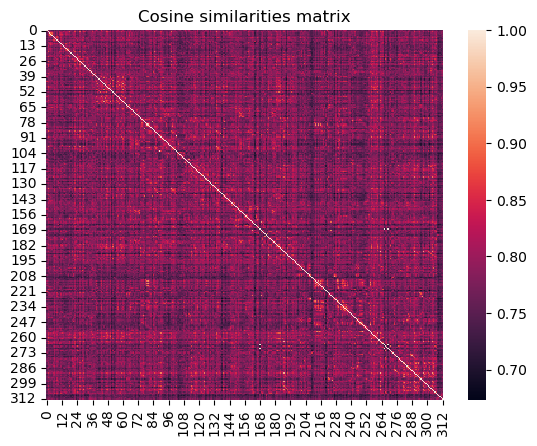

In [955]:
# Create similarities matrix
similarities = cosine_similarity(embeddings)
# Lets plot the result we got
sns.heatmap(similarities).set_title('Cosine similarities matrix');

#Print the values of consine similarity
print ("Consine Similarity: ", similarities)
print ("Data Type: ", type(similarities))

<h2>Find splitting points</h2>

C:\Users\WC\anaconda3\envs\preprocessing\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\WC\anaconda3\envs\preprocessing\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\WC\anaconda3\envs\preprocessing\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\WC\anaconda3\envs\preprocessing\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

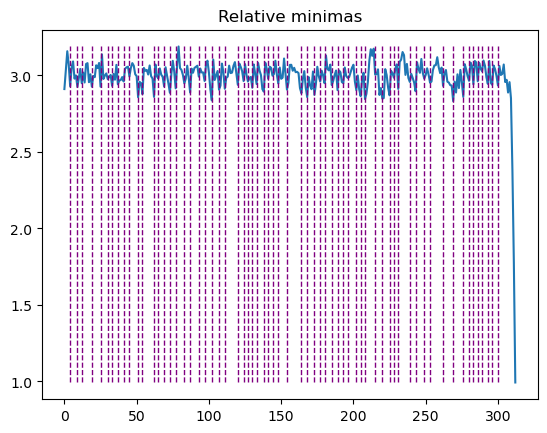

In [956]:
def rev_sigmoid(x:float)->float:
    return (1 / (1 + math.exp(0.5*x)))
    
def activate_similarities(similarities:np.array, p_size=100)->np.array:
        """ Function returns list of weighted sums of activated sentence similarities
        Args:
            similarities (numpy array): it should square matrix where each sentence corresponds to another with cosine similarity
            p_size (int): number of sentences are used to calculate weighted sum 
        Returns:
            list: list of weighted sums
        """
        # To create weights for sigmoid function we first have to create space. P_size will determine number of sentences used and the size of weights vector.
        x = np.linspace(-10,10,p_size)
        # Then we need to apply activation function to the created space
        y = np.vectorize(rev_sigmoid) 
        # Because we only apply activation to p_size number of sentences we have to add zeros to neglect the effect of every additional sentence and to match the length ofvector we will multiply
        activation_weights = np.pad(y(x),(0,similarities.shape[0]-p_size))
        ### 1. Take each diagonal to the right of the main diagonal
        diagonals = [similarities.diagonal(each) for each in range(0,similarities.shape[0])]
        ### 2. Pad each diagonal by zeros at the end. Because each diagonal is different length we should pad it with zeros at the end
        diagonals = [np.pad(each, (0,similarities.shape[0]-len(each))) for each in diagonals]
        ### 3. Stack those diagonals into new matrix
        diagonals = np.stack(diagonals)
        ### 4. Apply activation weights to each row. Multiply similarities with our activation.
        diagonals = diagonals * activation_weights.reshape(-1,1)
        ### 5. Calculate the weighted sum of activated similarities
        activated_similarities = np.sum(diagonals, axis=0)
        return activated_similarities

# Let's apply our function. For long sentences i reccomend to use 10 or more sentences
activated_similarities = activate_similarities(similarities, p_size=7)

# Let's create empty fig for our plor
fig, ax = plt.subplots()
### 6. Find relative minima of our vector. For all local minimas and save them to variable with argrelextrema function
minmimas = argrelextrema(activated_similarities, np.less, order=2) #order parameter controls how frequent should be splits. I would not reccomend changing this parameter.
# plot the flow of our text with activated similarities
sns.lineplot(y=activated_similarities, x=range(len(activated_similarities)), ax=ax).set_title('Relative minimas');
# Now lets plot vertical lines in order to see where we created the split
plt.vlines(x=minmimas, ymin=min(activated_similarities), ymax=max(activated_similarities), colors='purple', ls='--', lw=1, label='vline_multiple - full height')

In [957]:
# import numpy as np
# def sigmoid(x: float) -> float:
#     """Sigmoid activation function."""
#     return 1 / (1 + math.exp(-x))

# def apply_activation_weights(similarities: np.array, activation_function, p_size=25) -> np.array:
#     """ Apply activation weights to the similarity matrix.
    
#     Args:
#         similarities (numpy array): Square matrix of cosine similarities.
#         activation_function: Function to apply for activation.
#         p_size (int): Number of sentences to calculate weighted sum.

#     Returns:
#         np.array: Weighted sums of activated sentence similarities.
#     """
#     # Creating a symmetric weight distribution around zero
#     x = np.linspace(-5, 5, p_size)
#     f2 = np.vectorize(activation_function)
#     weights = f2(x)
#     activation_weights = np.pad(weights, (0, similarities.shape[0] - p_size), 'constant')

#     # Apply activation weights to the upper triangle of the matrix
#     upper_triangular = np.triu(similarities)
#     weighted_similarities = upper_triangular * activation_weights[:, np.newaxis]

#     # Summing over columns to get the activated similarities
#     activated_similarities = np.sum(weighted_similarities, axis=0)
#     return activated_similarities

# def find_split_points(activated_similarities, order=2):
#     """ Find split points in the activated similarities.
    
#     Args:
#         activated_similarities (np.array): Activated similarity scores.
#         order (int): Determines the range of comparison for finding local minima.

#     Returns:
#         np.array: Indices of split points.
#     """
#     # Find local minima as potential split points
#     split_points = argrelextrema(activated_similarities, np.less, order=order)[0]
#     return split_points

# def plot_split_points(activated_similarities, split_points):
#     """ Plot the activated similarities and split points.
    
#     Args:
#         activated_similarities (np.array): Activated similarity scores.
#         split_points (np.array): Indices of split points.
#     """
#     plt.figure(figsize=(10, 6))
#     sns.lineplot(y=activated_similarities, x=range(len(activated_similarities))).set_title('Activated Similarities with Split Points')
#     plt.vlines(x=split_points, ymin=min(activated_similarities), ymax=max(activated_similarities), colors='purple', ls='--', lw=1)
#     plt.show()

# # Example Usage
# # similarities = ... # Your similarity matrix
# activated_similarities = apply_activation_weights(similarities, sigmoid, p_size=7)
# split_points = find_split_points(activated_similarities)
# plot_split_points(activated_similarities, split_points)

<h3> Zoom in to see the results </h3>

C:\Users\WC\anaconda3\envs\preprocessing\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\WC\anaconda3\envs\preprocessing\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\WC\anaconda3\envs\preprocessing\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\WC\anaconda3\envs\preprocessing\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

(0.0, 100.0)

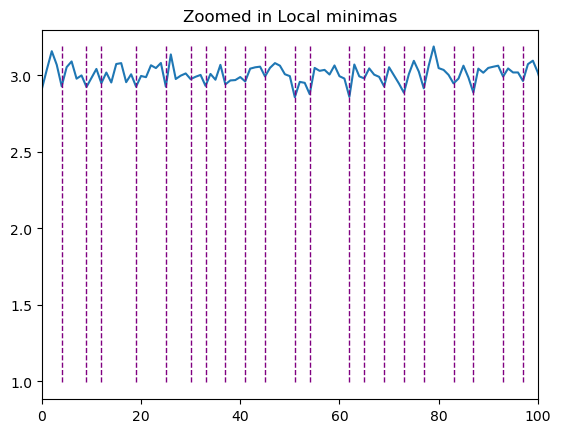

In [958]:
fig, ax = plt.subplots()
# for all local minimals
sns.lineplot(y=activated_similarities, x=range(len(activated_similarities)), ax=ax).set_title('Zoomed in Local minimas');
# Now lets plot vertical line in order to understand if we have done what we wanted
plt.vlines(x=minmimas, ymin=min(activated_similarities), ymax=max(activated_similarities), colors='purple', ls='--', lw=1, label='vline_multiple - full height')
ax.set_xlim([0,100])

<h2>Split the text in paragraphs</h2>

In [959]:
# # Create empty string
# print(split_points[0])
# split_points = [each for each in split_points[0]]
# text = ''
# for num,each in enumerate(sentences):
#     if num in split_points:
#         text+=f'\n\n {each}. '
#     else:
#         text+=f'{each}. '

# Create empty string
# print( minmimas[0])
split_points = [each for each in minmimas[0]]
text = ''
for num,each in enumerate(sentences):
    if num in split_points:
        text+=f'\n\n {each}. '
    else:
        text+=f'{each}. '
print(text)

pWnOS 1.0 can be downloaded from <https://Awww.vulnhub.com/entry/pwnos-10,33/>.. The provided content appears to be a list of two IP addresses (192.168.1.19 and 192.168.1.23) separated by a line break. An IP address is a unique identifier assigned to every device connected to the internet or a network. These IP addresses can be used to identify and communicate with specific devices on a network. 

 In simple terms, think of an IP address as a phone number for devices on a network, allowing them to communicate with each other.. The computer is starting up and running various programs and services. It is starting the "kernel log daemon," which records information about the system's operation, and the "OpenBSD Secure Shell server sshd," which allows remote users to access the system securely. The system is also checking for issues with its MySQL database server, Samba file-sharing service, and Winbind daemon. Additionally, it is starting a scheduler for running regular tasks and a web ser

In [960]:
text_file = open("output.txt", "w", encoding="utf-8")
text_file.write(text)
text_file.close()

In [961]:
# Path to your text file
file_path = "output.txt"
sentences = []
# Open the file and read it line by line
with open(file_path, 'r', encoding="utf-8") as file:
    for line in file:
        # Each 'line' is a sentence
        sentence = line.strip()  # Remove any leading/trailing whitespace
        # Process the sentence as needed
        sentences.append(sentence)
paragraph = []
for sentence in sentences:
    if sentence != "":
        paragraph.append(sentence)
print(len(paragraph))

66


In [962]:
import openpyxl
import os
# Path to your Excel file
file_path = "ctf_data.xlsx"

# Check if the file exists
if not os.path.exists(file_path):
    # Create a new workbook
    workbook = openpyxl.Workbook()
    # Optionally, you can add data or modify the workbook here

    # Save the new workbook
    workbook.save(file_path)
    print(f"Created a new Excel file: {file_path}")

# Open the Excel file
workbook = openpyxl.load_workbook(file_path)

# Select the active sheet or specify the sheet if you know the name
sheet = workbook.active  # or workbook['Sheet1']


index = 0
ctf_folder = "url_91"
for p in paragraph:
    # Your data list to append
    data_to_append = [ctf_folder, ctf_folder +"_{x}".format(x=index), "NaN",p]


    # Find the next row in the sheet
    next_row = sheet.max_row + 1

    # Append data to the next row
    for col, entry in enumerate(data_to_append, start=1):
        sheet.cell(row=next_row, column=col, value=entry)

    # Save the workbook
    workbook.save(file_path)
    
    # Update the index
    index += 1